In [1]:
import os, json

import pandas as pd
import numpy as np
from openai import OpenAI
import sklearn.metrics as metrics
import seaborn as sns


input_dir = "resources/mu_codebook/out/"

input_files = os.listdir(input_dir)
input_files = [os.path.join(input_dir, f) for f in input_files if f.endswith("json")]
input_files

/tmp/ipykernel_169415/498147681.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['resources/mu_codebook/out/code97.json',
 'resources/mu_codebook/out/code101.json',
 'resources/mu_codebook/out/code79.json',
 'resources/mu_codebook/out/code67.json',
 'resources/mu_codebook/out/code71.json',
 'resources/mu_codebook/out/code92.json',
 'resources/mu_codebook/out/code74.json',
 'resources/mu_codebook/out/code76.json',
 'resources/mu_codebook/out/code73.json',
 'resources/mu_codebook/out/code89.json',
 'resources/mu_codebook/out/code68.json',
 'resources/mu_codebook/out/code86.json',
 'resources/mu_codebook/out/code84.json',
 'resources/mu_codebook/out/code72.json',
 'resources/mu_codebook/out/code93.json',
 'resources/mu_codebook/out/code96.json',
 'resources/mu_codebook/out/code77.json',
 'resources/mu_codebook/out/code98.json',
 'resources/mu_codebook/out/code70.json',
 'resources/mu_codebook/out/code81.json',
 'resources/mu_codebook/out/code85.json',
 'resources/mu_codebook/out/code100.json',
 'resources/mu_codebook/out/code80.json',
 'resources/mu_codebook/out/code

In [2]:
# read files into pandas dataframes

def read(path):
    with open(path, "r") as f:
        data = json.load(f)
        
        # create dataframe at variable level
        df = pd.DataFrame(data["variables"])
        
        # join with the dataset level information
        df["title"] = data["title"]
        df["date"] = data["date"]

        return df

dfs = [read(f) for f in input_files]
df = pd.concat(dfs).reset_index(drop=True)

In [3]:
# TODO: prevent passing the whole list since OpenAI API has a length limit
# get using OpenAI API
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def get_embedding(input):
    chunks = [input[i:i+2000] for i in range(0, len(input), 2000)]
    embeddings = []

    for chunk in chunks:
        response = client.embeddings.create(
            input=chunk,
            model="text-embedding-3-small"
        )
        embeddings += [d.embedding for d in response.data]

    return embeddings

# embed variable name and description together
df["to_embed"] = df["name"] + " " + df["description"]

df["embedding"] = get_embedding(df["to_embed"].to_list())

In [4]:
from sklearn.cluster import KMeans, DBSCAN

# Find maxiumum number of variables
max_num_of_vars = df.groupby("date")["name"].count().max()

# Create the k-means clustering model
model = KMeans(n_clusters=max_num_of_vars, max_iter=3000, random_state=42)

# Create the DBSCAN clustering model
# model = DBSCAN(eps=0.5, min_samples=3)

# Fit the model to the data
model.fit(df["embedding"].tolist())

# Get the cluster labels for each observation
cluster_labels = model.labels_

# Add the cluster labels to the dataframe
df["cluster"] = cluster_labels

# Print the dataframe with the cluster labels
print(df.cluster.value_counts())

df_sorted = df.sort_values(by=["cluster", "date"])

df_sorted[["cluster", "date", "name", "description"]].to_csv(".cache/clustered.csv", index=False)

cluster
5      162
61      66
20      66
46      58
45      50
      ... 
105      7
35       7
99       7
102      7
47       6
Name: count, Length: 107, dtype: int64


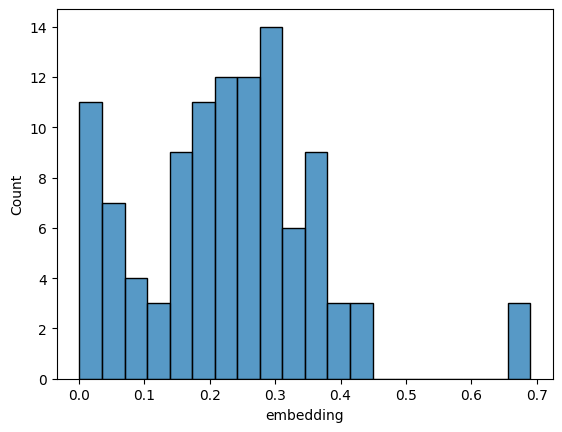

In [5]:
def msd(df):
    # sum of squared distances to the cluster center
    embed_matrix = np.array(df.to_list())
    return np.mean(np.linalg.norm(embed_matrix - np.mean(embed_matrix, axis=0), axis=1))


# within-cluster mean squared distances
# to identify clusters with high variance
within_cluster_msd = (
    df_sorted.groupby("cluster")["embedding"].agg(msd).sort_values(ascending=False)
)
plt = sns.histplot(within_cluster_msd, bins=20)

df_sorted["msd"] = within_cluster_msd[df_sorted["cluster"]].to_list()

df_sorted.sort_values(by="msd", ascending=False)[
    ["cluster", "date", "name", "description", "msd"]
].to_csv(".cache/clustered_msd.csv", index=False)

In [6]:
def recommend_top_n(df, q, n = 10):
    # calculate the distance matrix
    df_dist = metrics.pairwise_distances(df["embedding"].tolist(), metric="euclidean")
    df_dist = pd.DataFrame(df_dist)

    # get the top n closest variables to the query
    print(df_dist.iloc[q, :])
    closest = df_dist.iloc[q].sort_values().head(n)
    
    # return the closest variables
    return df.iloc[closest.index]

recommend_top_n(df, 300, 30)

0       1.249206
1       1.238676
2       1.282883
3       1.290300
4       1.325332
          ...   
2862    1.120819
2863    1.112521
2864    1.126636
2865    1.225823
2866    1.290356
Name: 300, Length: 2867, dtype: float64


,description,field,name,note,q_id,values,title,date,to_embed,embedding,cluster
300,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,67年人力運用調查,1978,b23_y 你從事這項工作有多久了？__年,"[0.009278344921767712, 0.02209901623427868, 0....",62
604,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,76年人力運用調查,1987,b23_y 你從事這項工作有多久了？__年,"[0.009278344921767712, 0.02209901623427868, 0....",62
529,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,74年人力運用調查,1985,b23_y 你從事這項工作有多久了？__年,"[0.009278344921767712, 0.02209901623427868, 0....",62
373,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,71年人力運用調查,1982,b23_y 你從事這項工作有多久了？__年,"[0.009278344921767712, 0.02209901623427868, 0....",62
1024,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,72年人力資源暨人力運用調查,1983,b23_y 你從事這項工作有多久了？__年,"[0.009278344921767712, 0.02209901623427868, 0....",62
1842,你從事這項工作有多久了？__年,1/74-75,b23_y,,23,0.0年或跳答、不適用,69年人力運用調查,1980,b23_y 你從事這項工作有多久了？__年,"[0.009254288859665394, 0.022120008245110512, 0...",62
2836,你從事這項工作有多久了？﹍年,1/74-75,b23_y,,23,0.0年或跳答、不適用,75年人力運用調查,1986,b23_y 你從事這項工作有多久了？﹍年,"[0.010045262984931469, 0.0273950956761837, 0.0...",62
785,你從事這項工作有多久了？﹍年,1/74-75,b23_y,,23,0.0年或跳答、不適用,68年人力運用調查,1979,b23_y 你從事這項工作有多久了？﹍年,"[0.010069343261420727, 0.027372512966394424, 0...",62
1433,你從事這項工作有多久了？﹍年,1/74-75,b23_y,,23,0.0年或跳答、不適用,70年人力運用調查,1981,b23_y 你從事這項工作有多久了？﹍年,"[0.010069343261420727, 0.027372512966394424, 0...",62
1025,你從事這項工作有多久了？__月,1/76-77,b23_m,,23,0.0月或跳答、不適用,72年人力資源暨人力運用調查,1983,b23_m 你從事這項工作有多久了？__月,"[0.009266592562198639, 0.017179317772388458, 0...",62
